In [92]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

**Util function**

In [93]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [94]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_mlp_encoder_cond_lung/518262b2-2b9a-41f5-a9cd-2d74f9e22035/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [95]:
dataset_config = {'dataset_path': '../../datasets/processed/lung_atlas.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'sampling_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_encoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

generative_model_config = {'x0_from_x_kwargs': {
                                'dims': [512, 512],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 200,
                            'sigma': 0.5,
                            'covariate_specific_theta': False
                        }

**Initialization**

Initialize dataset 

In [96]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        target_max=dataset_config["target_max"], 
                        target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


Initialize feature embeddings

In [6]:
feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [7]:
generative_model = FM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            model_type=denoising_model.model_type,
            conditioning_covariate="clusters",
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (denoising_model): SimpleMLPTimeStep(
    (net): Sequential(
      (0): Linear(in_features=2019, out_features=1000, bias=True)
      (1): SELU()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): SELU()
      (4): Linear(in_features=1000, out_features=1000, bias=True)
      (5): SELU()
      (6): Linear(in_features=1000, out_features=2000, bias=True)
    )
  )
  (criterion): MSELoss()
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2000, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=512, out_features=2000, bias=True)
    )
  )
)

**Check the data**

In [8]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

In [72]:
num_indices = 10000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

# classes =  list(adata_indices.obs.cell_type)
# classes = torch.tensor([dataset.id2cov["cell_type"][c] for  c in classes]).cuda()
classes = 1*torch.ones(num_indices).long()

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [73]:
X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=100,
                                                n_sample_steps=1000, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

**Create adata and check plots**

In [74]:
adata_generated = sc.AnnData(X=deepcopy(X_generated).cpu().numpy())

In [75]:
# sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [76]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

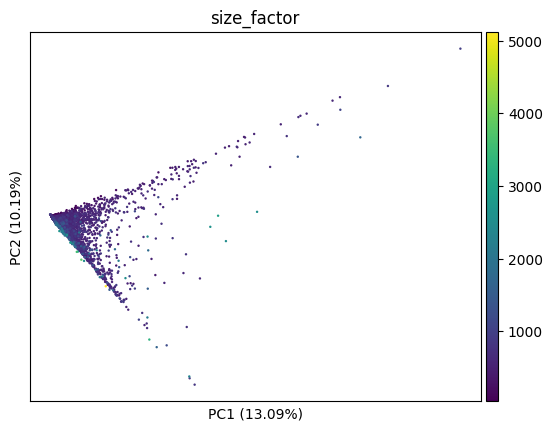

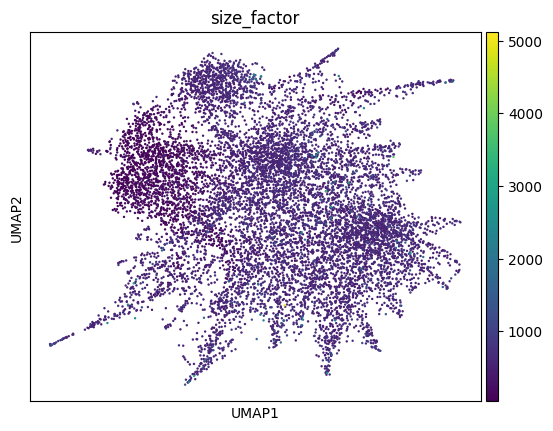

In [77]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

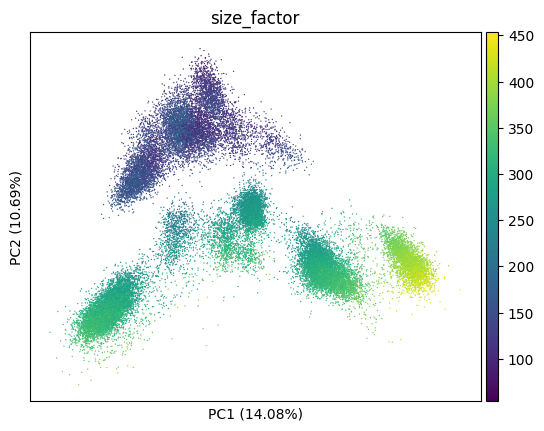

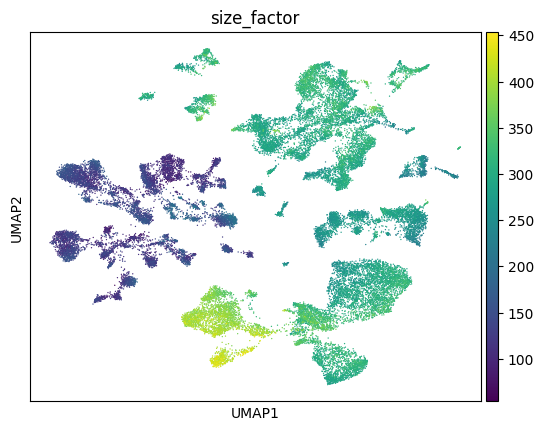

In [78]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [79]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]

In [80]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [81]:
adata_original

AnnData object with n_obs × n_vars = 32472 × 2000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'size_factor'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_colors', 'donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts'
    obsp: 'connectivities', 'distances'

In [82]:
# sc.pp.normalize_total(adata_merged)
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


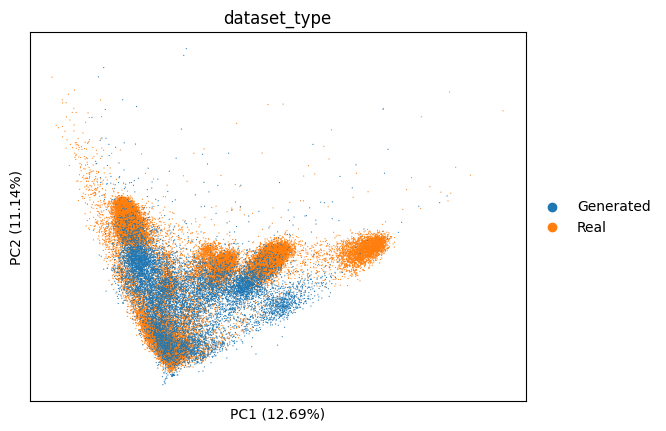

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


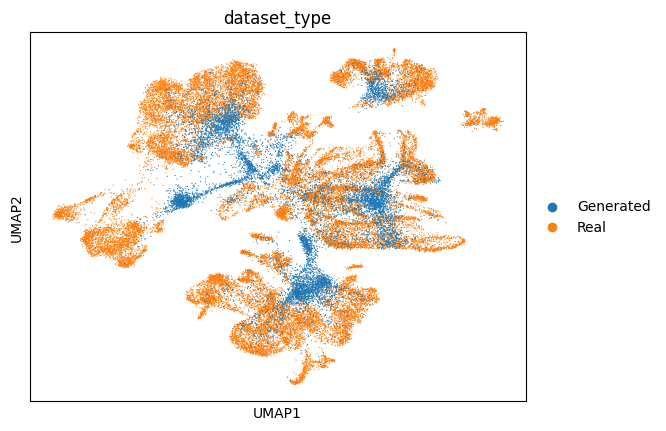

In [83]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


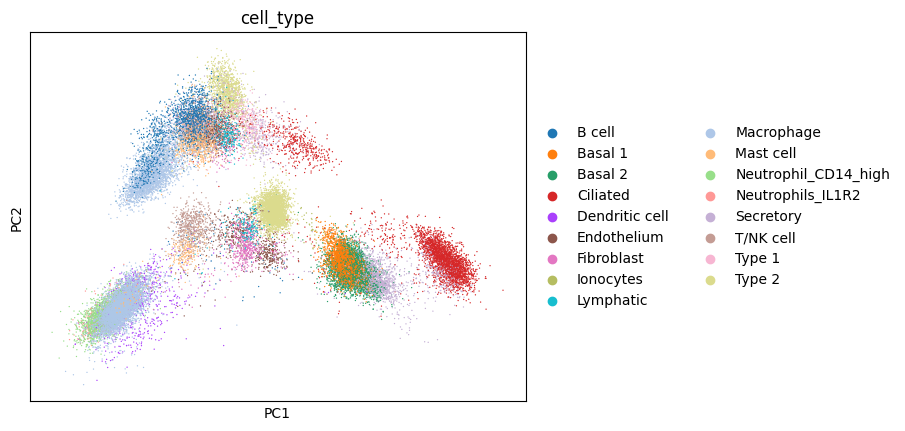

In [84]:
sc.pl.pca(adata_original, color="cell_type")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


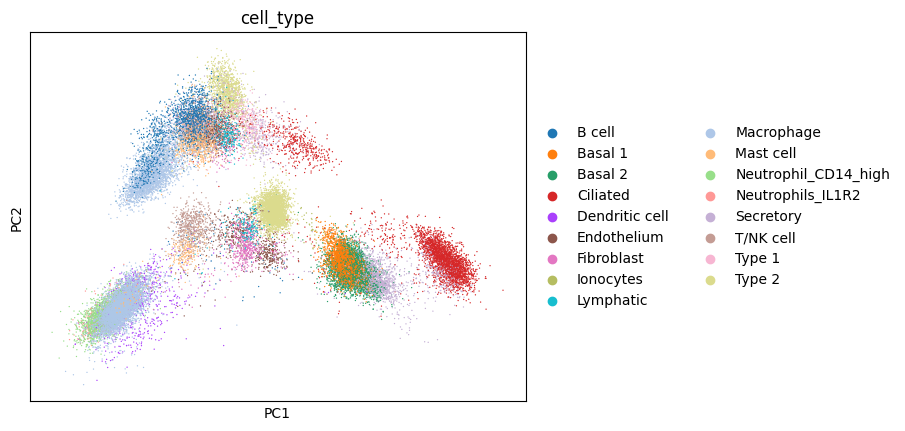

In [85]:
sc.pl.pca(adata_original, color="cell_type")

(array([1.840e+02, 6.530e+02, 5.140e+02, 2.960e+02, 2.290e+02, 2.550e+02,
        3.240e+02, 5.670e+02, 1.380e+03, 2.094e+03, 1.604e+03, 5.370e+02,
        2.780e+02, 3.280e+02, 3.140e+02, 1.680e+02, 3.800e+01, 2.800e+01,
        2.900e+01, 1.400e+01, 1.600e+01, 1.600e+01, 1.100e+01, 1.200e+01,
        1.800e+01, 1.000e+01, 8.000e+00, 7.000e+00, 6.000e+00, 5.000e+00,
        1.000e+00, 3.000e+00, 8.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        4.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

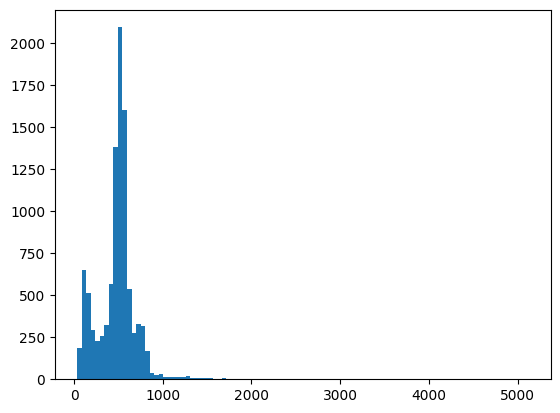

In [86]:
plt.hist(X_generated.sum(1), 100)

# 

(array([1.527e+03, 2.527e+03, 1.452e+03, 9.280e+02, 1.130e+03, 1.951e+03,
        6.855e+03, 9.159e+03, 2.699e+03, 1.049e+03, 1.579e+03, 8.440e+02,
        1.170e+02, 9.300e+01, 7.900e+01, 4.700e+01, 5.000e+01, 5.300e+01,
        4.500e+01, 4.400e+01, 2.400e+01, 2.500e+01, 2.000e+01, 2.200e+01,
        1.800e+01, 1.000e+01, 1.300e+01, 1.400e+01, 5.000e+00, 7.000e+00,
        8.000e+00, 1.000e+01, 6.000e+00, 2.000e+00, 5.000e+00, 6.000e+00,
        4.000e+00, 1.000e+01, 4.000e+00, 4.000e+00, 3.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

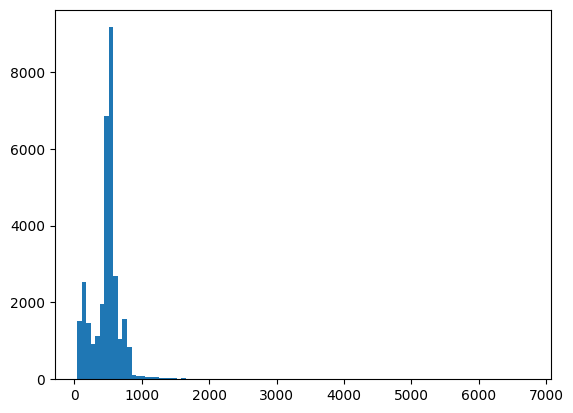

In [87]:
plt.hist(X.sum(1), 100)

In [88]:
(X_generated==0).sum(1).float().mean()

tensor(1841.7162)

In [89]:
(X==0).sum(1).float().mean()

tensor(1718.2449)

In [90]:
X.mean(1).mean()

tensor(0.2440)

In [91]:
X_generated.mean(1).mean()

tensor(0.2448)

In [98]:
ad = sc.read_h5ad('../../datasets/processed/lung_atlas.h5ad')

In [107]:
1500*(32472/64)

761062.5